<a href="https://colab.research.google.com/github/NunezKant/COVID19_MEX_MASTER/blob/master/Probabilistic_Fit_SEAIR_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install pymc3==3.8

In [0]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

In [0]:
def TimeSeriesLoader(url):
  df = pd.read_csv(url)

  df['Reporte'] = pd.to_datetime(df['Reporte'])
  df = (df.drop(["Procedencia", "Llegada","Inicio","Caso","Sexo","Edad","Confirmación"], axis=1)
          .dropna()
          .rename(columns = {"Reporte":"Dia"})
          .sort_values(by = ["Dia"])
          .reset_index(drop = True)
        )
  df["Casos_Acumulados"] = np.nan
  Estados = pd.DataFrame({
    "Estado":[],
    "Dia":[],
    "Casos_Acumulados":[]
  })

  for estado in df.Estado.unique():
      df.loc[(df.Estado == estado),"Casos_Acumulados"] =  np.arange(1,len(df.loc[(df.Estado == estado),"Casos_Acumulados"])+1,1)
      tmp = df.loc[df.Estado == estado].drop_duplicates("Dia", keep = 'last').reset_index(drop = True)
      Estados = pd.concat([Estados,tmp])
  return Estados

In [0]:
"""
y[0] = S
y[1] = E
y[2] = A
y[3] = I
y[4] = R
y[5] = D

p[0] = Beta
p[1] = Alpha
p[2] = Gamma
p[3] = Rho
p[4] = Kappa

St = S[-1] - (beta*S[-1]*I[-1])*dt
Et = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
At = A[-1] + (1-rho)*(alpha*E[-1] - gamma*A[-1])*dt
It = I[-1] + rho*(alpha*E[-1] - gamma*I[-1])*dt
Dt = kappa*I[-1]
Rt = 1 - (S[-1]+E[-1]+A[-1]+I[-1]-D[-1])
"""

def SEAIR_M(y, t, p):
    ds = -p[0]*y[0]*y[3]
    de = p[0]*y[0]*y[3] - p[1]*y[1]
    da = (1-p[3])*(p[1]*y[1] - p[2]*y[2])
    di = p[3]*(p[1]*y[1] - p[2]*y[3])
    dm = p[4]*y[3]      
    dr = 1- (y[0]+y[1]+y[2]+y[3]+y[5])
    return [ds, de, da, di, dr, dm]



In [0]:
np.random.seed(666)

#(2020-03-14)
Population = 8000000
I_o = 2 / Population  # Tenemos 32 casos
E_o = (2*4)/ Population # Asumimos 4 expuestos por caso
A_o = 0
D_o = 0 # No Muertos
S_o = (1) - (E_o+I_o+A_o+D_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

dias_evaluacion = 120
dt=.01
periodo_evaluacion = np.arange(0,dias_evaluacion+dt,dt)

R_o = 3.5 #Escenario Base
alpha = 0.2
gamma = 0.5
rho = 0.82
kappa = .016
beta = R_o * gamma

y0 = np.array([S_o,E_o,A_o,I_o,R_o,D_o])

args = ((beta, alpha, gamma, rho,kappa,),)
 
y = odeint(SEAIR_M,t=periodo_evaluacion,y0=y0, args=args, rtol=1e-08)


In [0]:
Estados = TimeSeriesLoader("https://gist.githubusercontent.com/said3427/18f39eab460766a17ea4802607dd5522/raw") #Leer Datos

In [41]:
Estados.loc[Estados.Estado == "Jalisco"]

,Estado,Dia,Casos_Acumulados
0,Jalisco,2020-03-14,2.0
1,Jalisco,2020-03-17,5.0
2,Jalisco,2020-03-18,6.0
3,Jalisco,2020-03-19,22.0
4,Jalisco,2020-03-20,38.0
5,Jalisco,2020-03-21,44.0
6,Jalisco,2020-03-22,53.0
7,Jalisco,2020-03-23,57.0
8,Jalisco,2020-03-26,69.0
9,Jalisco,2020-03-27,82.0


In [0]:
yobs = Estados.loc[Estados.Estado == "Jalisco","Casos_Acumulados"].values
date  = Estados.loc[Estados.Estado == "Jalisco","Dia"].values

In [0]:
# Esto no encontré como hacerlo bonito
# Tomando en cuenta que el dia 0 es 14 de marzo

#  14 , 17:23 , 26, 27
amdl = np.array([y[0,2],y[300,2],y[400,2],y[500,2],y[600,2],y[700,2],y[800,2],y[900,2],y[1200,2],y[1300,2]])*Population
ymdl = np.array([y[0,3],y[300,3],y[400,3],y[500,3],y[600,3],y[700,3],y[800,3],y[900,3],y[1200,3],y[1300,3]])*Population

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


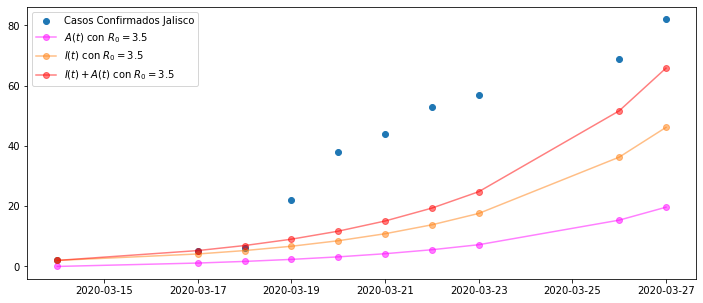

In [44]:
## Primeras 5 observaciones
plt.figure(figsize=(12,5))
plt.plot(date,yobs, marker='o', linestyle='none', label = "Casos Confirmados Jalisco")
plt.plot(date,amdl, marker ='o',color = 'magenta', alpha=0.5, label=f'$A(t)$ con $R_0 = {R_o}$')
plt.plot(date,ymdl, marker ='o',color = 'C1', alpha=0.5, label=f'$I(t)$ con $R_0 = {R_o}$')
plt.plot(date,ymdl+amdl, marker ='o',color = 'red', alpha=0.5, label=f'$I(t)+A(t)$ con $R_0 = {R_o}$')
plt.legend()
plt.show()

#Agregar observaciones

Necesito interpolar entre las fechas.

In [147]:
yobs

array([ 2.,  5.,  6., 22., 38., 44., 53., 57., 69., 82.])

In [0]:
def getDays(estado,FirstDay,dt):
  days = Estados.loc[Estados.Estado == estado,"Dia"].dt.day.values
  days = (days - FirstDay)* (1/dt)
  return days

In [0]:
days = getDays("Jalisco",14,dt)

In [0]:
from scipy.interpolate import InterpolatedUnivariateSpline
interp = InterpolatedUnivariateSpline(days,yobs,k=2)

Text(0.5, 0, 'Dias')

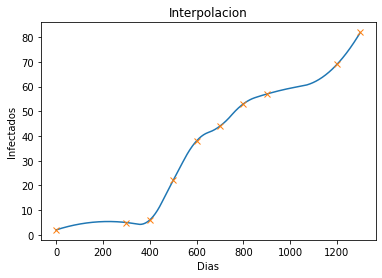

In [164]:
y_interp = interp(np.arange(0,days[-1],1))
plt.plot(np.arange(0,days[-1],1),y_interp)
plt.plot(days,yobs,"x")
plt.title("Interpolacion")
plt.ylabel("Infectados")
plt.xlabel("Dias")

In [0]:
def InitialConditions_Day(Population,i,r,d):
  """ 
  Produce los datos normalizados de S,E,I,R dados I y R del dia.
  """
  I = i / Population  # Tenemos 32 casos
  E = (i*4)/ Population # Asumimos 4 expuestos por caso
  A = np.round(i*.18,0)
  D = d # No Muertos
  S = (1) - (E_o+I_o+A_o+D_o) # El resto somos suceptibles
  R = r # NO hay ningun recuperado
  return [S, E, A, I, R, D]

def Construct_ObsVector(Iobs,pop,r,d):
  yobs_vector = np.empty((0,len(Iobs)*6))
  for obs in Iobs:
    CI = InitialConditions_Day(pop,obs,r,d)
    yobs_vector = np.append(yobs_vector,CI)
  return yobs_vector.reshape(len(Iobs),6)

In [0]:
yobs_vector = Construct_ObsVector(y_interp,Population,0,0)

In [0]:
SEAIRM_model = DifferentialEquation(
    func=SEAIR_M,
    times=periodo_evaluacion[:1300], #La primera observacion es el dia 13 y la ultima observación es el dia 27  y el dt es de 0.01
    n_states=6,
    n_theta=5,
)

In [174]:
with pm.Model() as model:
    
    alpha = 0.2
    gamma = 0.5
    rho = 0.82
    kappa = .016
    
    
    sigma = pm.HalfCauchy('sigma', 0.5)
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,1)
    p_beta = pm.Deterministic('beta', gamma*R0)

    """
    p[0] = Beta
    p[1] = Alpha
    p[2] = Gamma
    p[3] = Rho
    p[4] = Kappa

    Estoy dejando fijos los demas parámetros, por ahora, dado que hay muy ppocas observaciones de infectados confirmados
    """

 
    SEAIRM_curves = SEAIRM_model(y0=y0, theta=[p_beta, alpha, gamma, rho, kappa])
    Y = pm.Normal('Y', mu=SEAIRM_curves, sd=sigma, observed=yobs_vector)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000,tune=1000, target_accept=0.9, cores=2)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [R0, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [1:03:31<00:00,  1.57draws/s]
The acceptance probability does not match the target. It is 0.9605770955026585, but should be close to 0.9. Try to increase the number of tuning steps.
100%|██████████| 4000/4000 [04:03<00:00, 16.40it/s]


ERROR! Session/line number was not unique in database. History logging moved to new session 64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f380e7e43c8>,
      dtype=object)

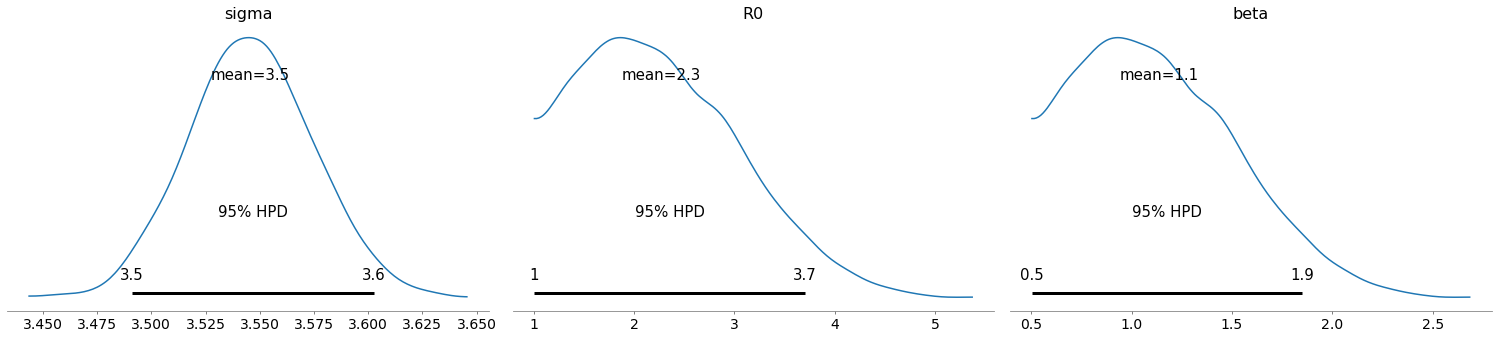

In [175]:
az.plot_posterior(data,round_to=2, credible_interval=0.95)

In [187]:
print(trace["R0"].mean()+trace["R0"].std())
print(trace["R0"].mean()-trace["R0"].std())

4.190101479272609
1.875961372622922
